In [1]:
import pandas as pd
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from autogluon.tabular import TabularPredictor

In [4]:
#leave empty

In [2]:
train_data = pd.read_csv('traindata.csv')
test_data = pd.read_csv('testdata_nolabels.csv')

In [3]:
fs = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27']
print(fs)

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27']


In [6]:
X = train_data[fs]
y = train_data['class']
X_test = test_data[fs]

In [5]:
memorization_dict = {tuple(row): label for row, label in zip(X.values, y)}
#check any same features in test and train
check = []
for row in test_data[fs].values:
    row_tuple = tuple(row)
    if row_tuple in memorization_dict:
        check.append(memorization_dict[row_tuple])
print(check)

[]


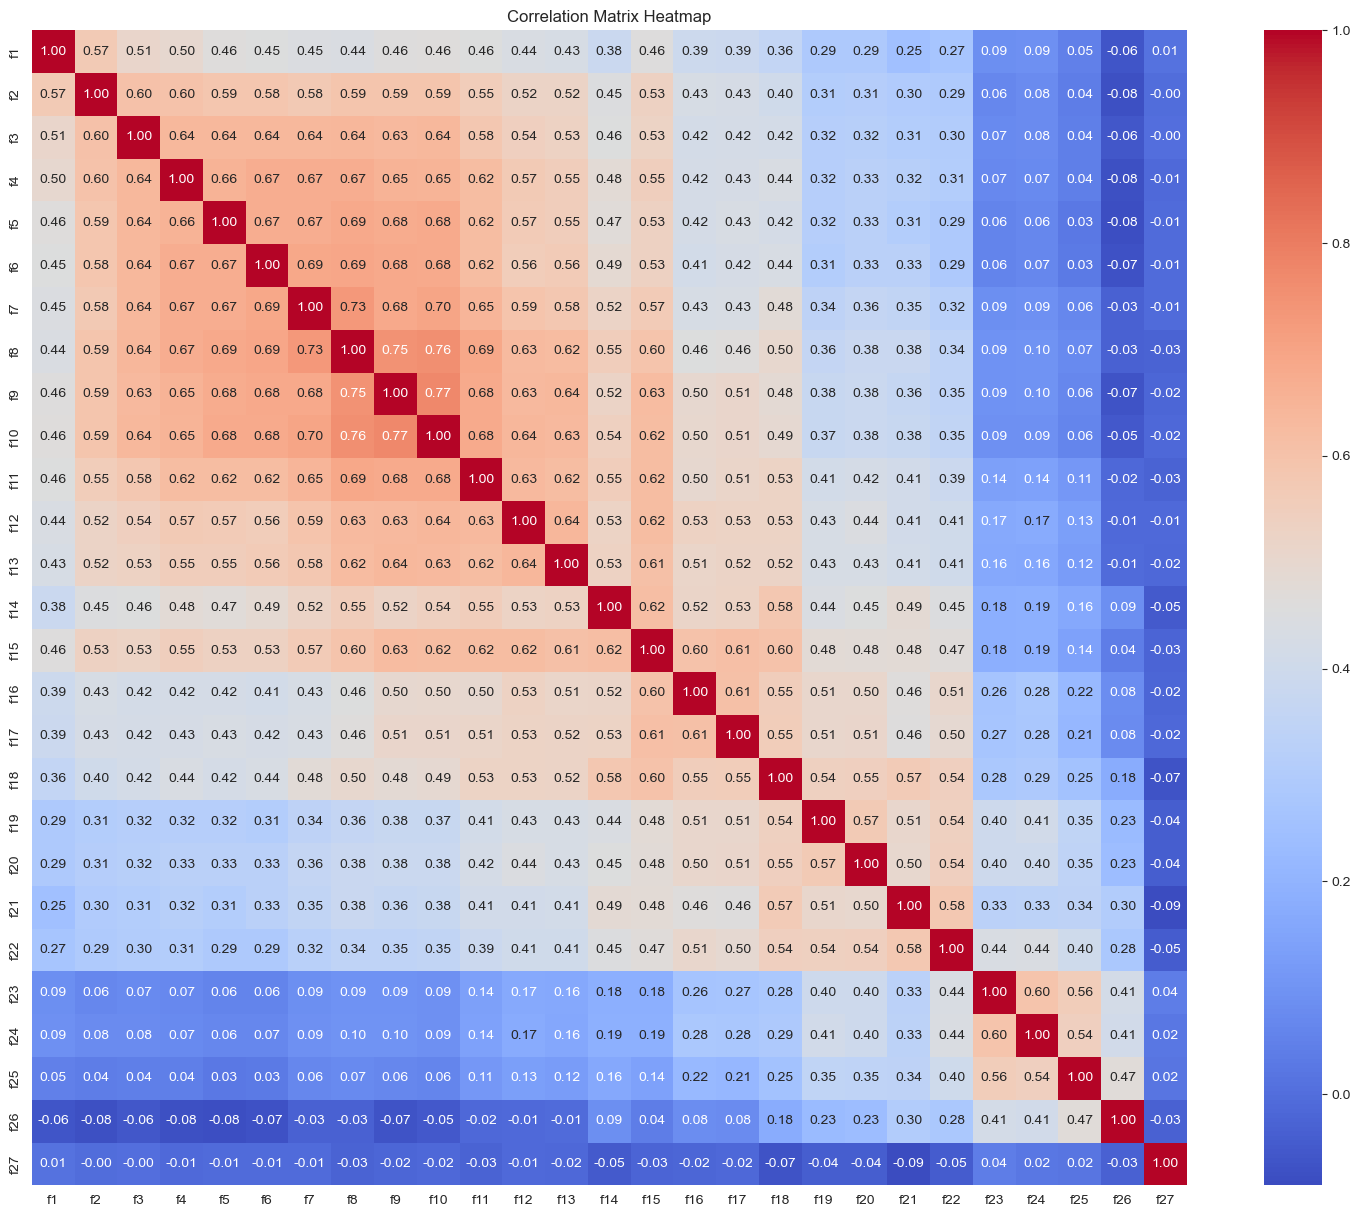

In [5]:
#check any high correlative features
corr_matrix = train_data[fs].corr()

# draw the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [18]:
#check largest correlation and the feature
np.fill_diagonal(corr_matrix.values, 0)
print(corr_matrix.max().max())
high_corr_pairs = [(fs[i], fs[j]) for i in range(1,27) for j in range(2, 27) if abs(corr_matrix.iloc[i, j]) > 0.75 and i<j]
print(high_corr_pairs)

0.7726138454419156
[('f8', 'f10'), ('f9', 'f10')]


In [19]:
#Check mean and std for features
means = X.mean()
std_devs = X.std()
print(means)
print(std_devs)

f1     11.339385
f2     14.869235
f3     17.026234
f4     21.011114
f5     21.799451
f6     22.641699
f7     26.516068
f8     30.865357
f9     28.599025
f10    28.972306
f11    32.639986
f12    31.774164
f13    31.941674
f14    33.473687
f15    34.148464
f16    27.155500
f17    27.592984
f18    33.919594
f19    26.257045
f20    26.451721
f21    31.363058
f22    27.985612
f23    11.309088
f24    11.546716
f25    12.919640
f26     5.189841
f27     2.672585
dtype: float64
f1      3.862345
f2      5.263704
f3      6.129513
f4      8.244076
f5      8.434996
f6      9.041629
f7     10.915503
f8     15.306882
f9     13.647324
f10    13.981402
f11    12.469049
f12    11.894245
f13    11.579051
f14    11.585600
f15    13.206601
f16     9.619491
f17     9.926031
f18    12.230371
f19     8.868715
f20     8.829376
f21    11.818121
f22    10.583804
f23     3.964813
f24     3.986010
f25     4.673925
f26     2.287270
f27     5.764628
dtype: float64


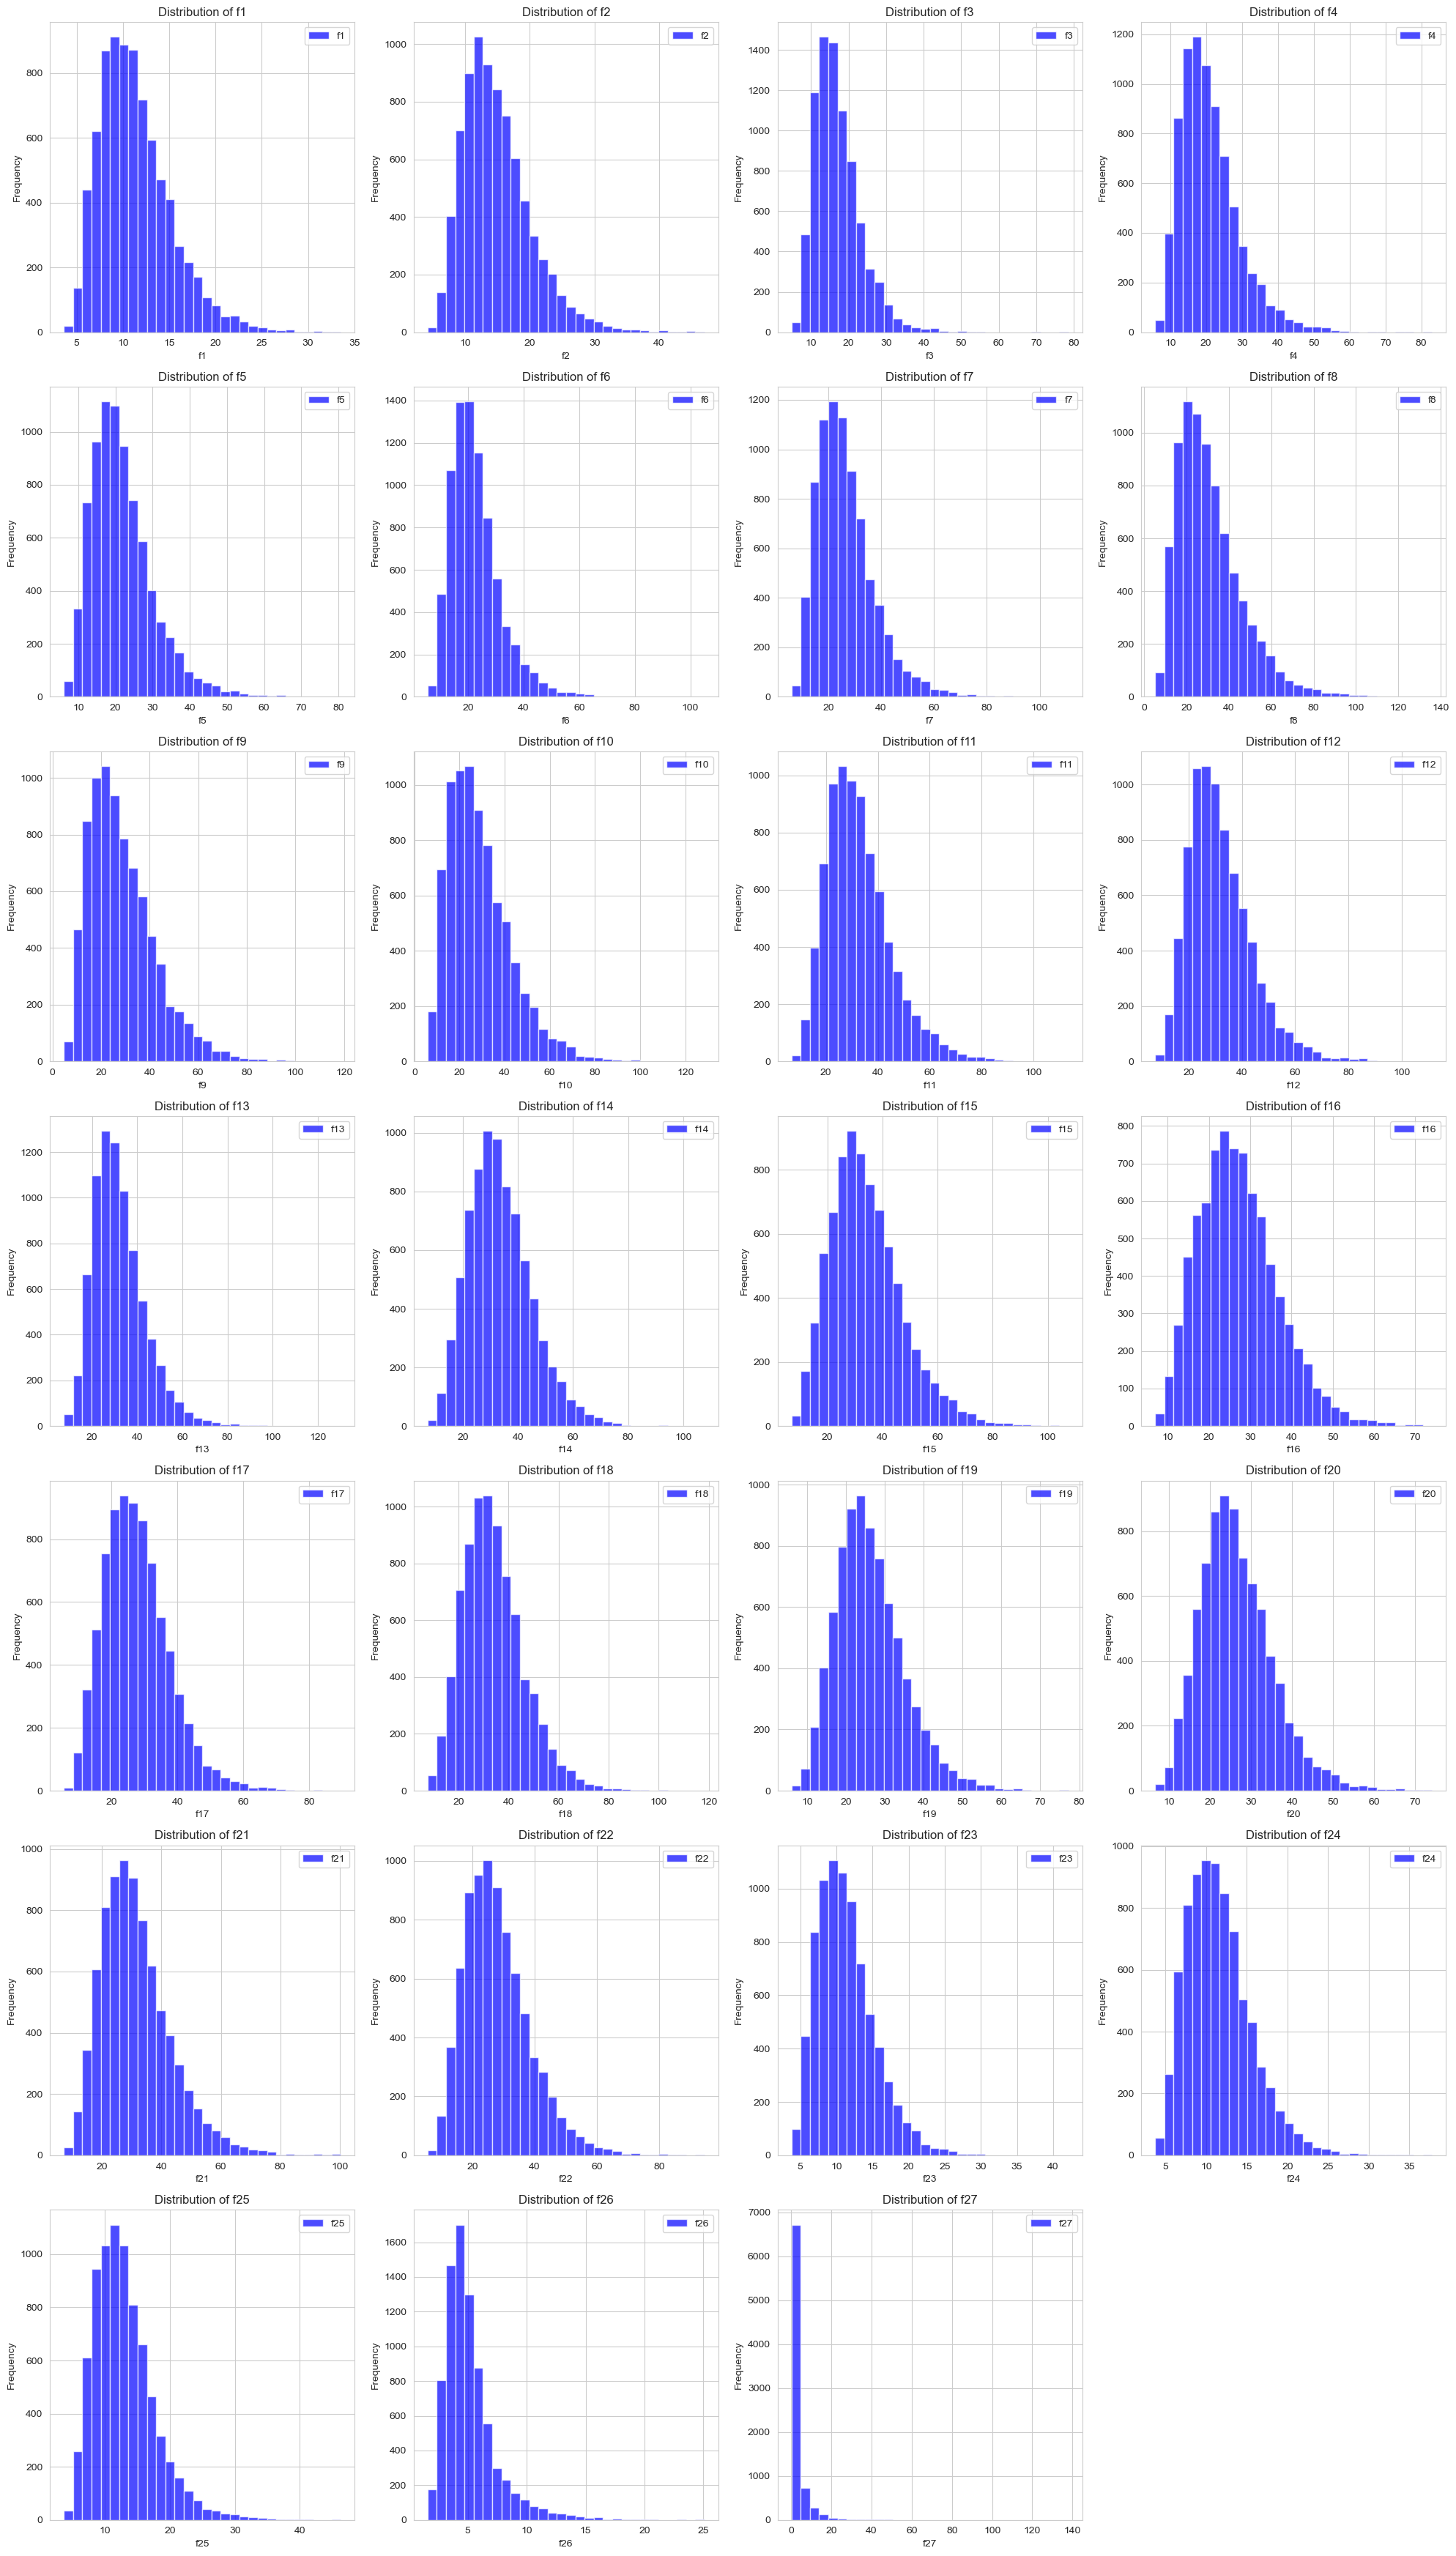

In [5]:
#Plot the hisgram of feature distribution
n_cols = 4 
n_rows = -(-len(fs) // n_cols)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))

for i, feature in enumerate(fs):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.hist(train_data[feature], bins=30, alpha=0.7, label=f'{feature}', color='blue')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {feature}')
    ax.legend()

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

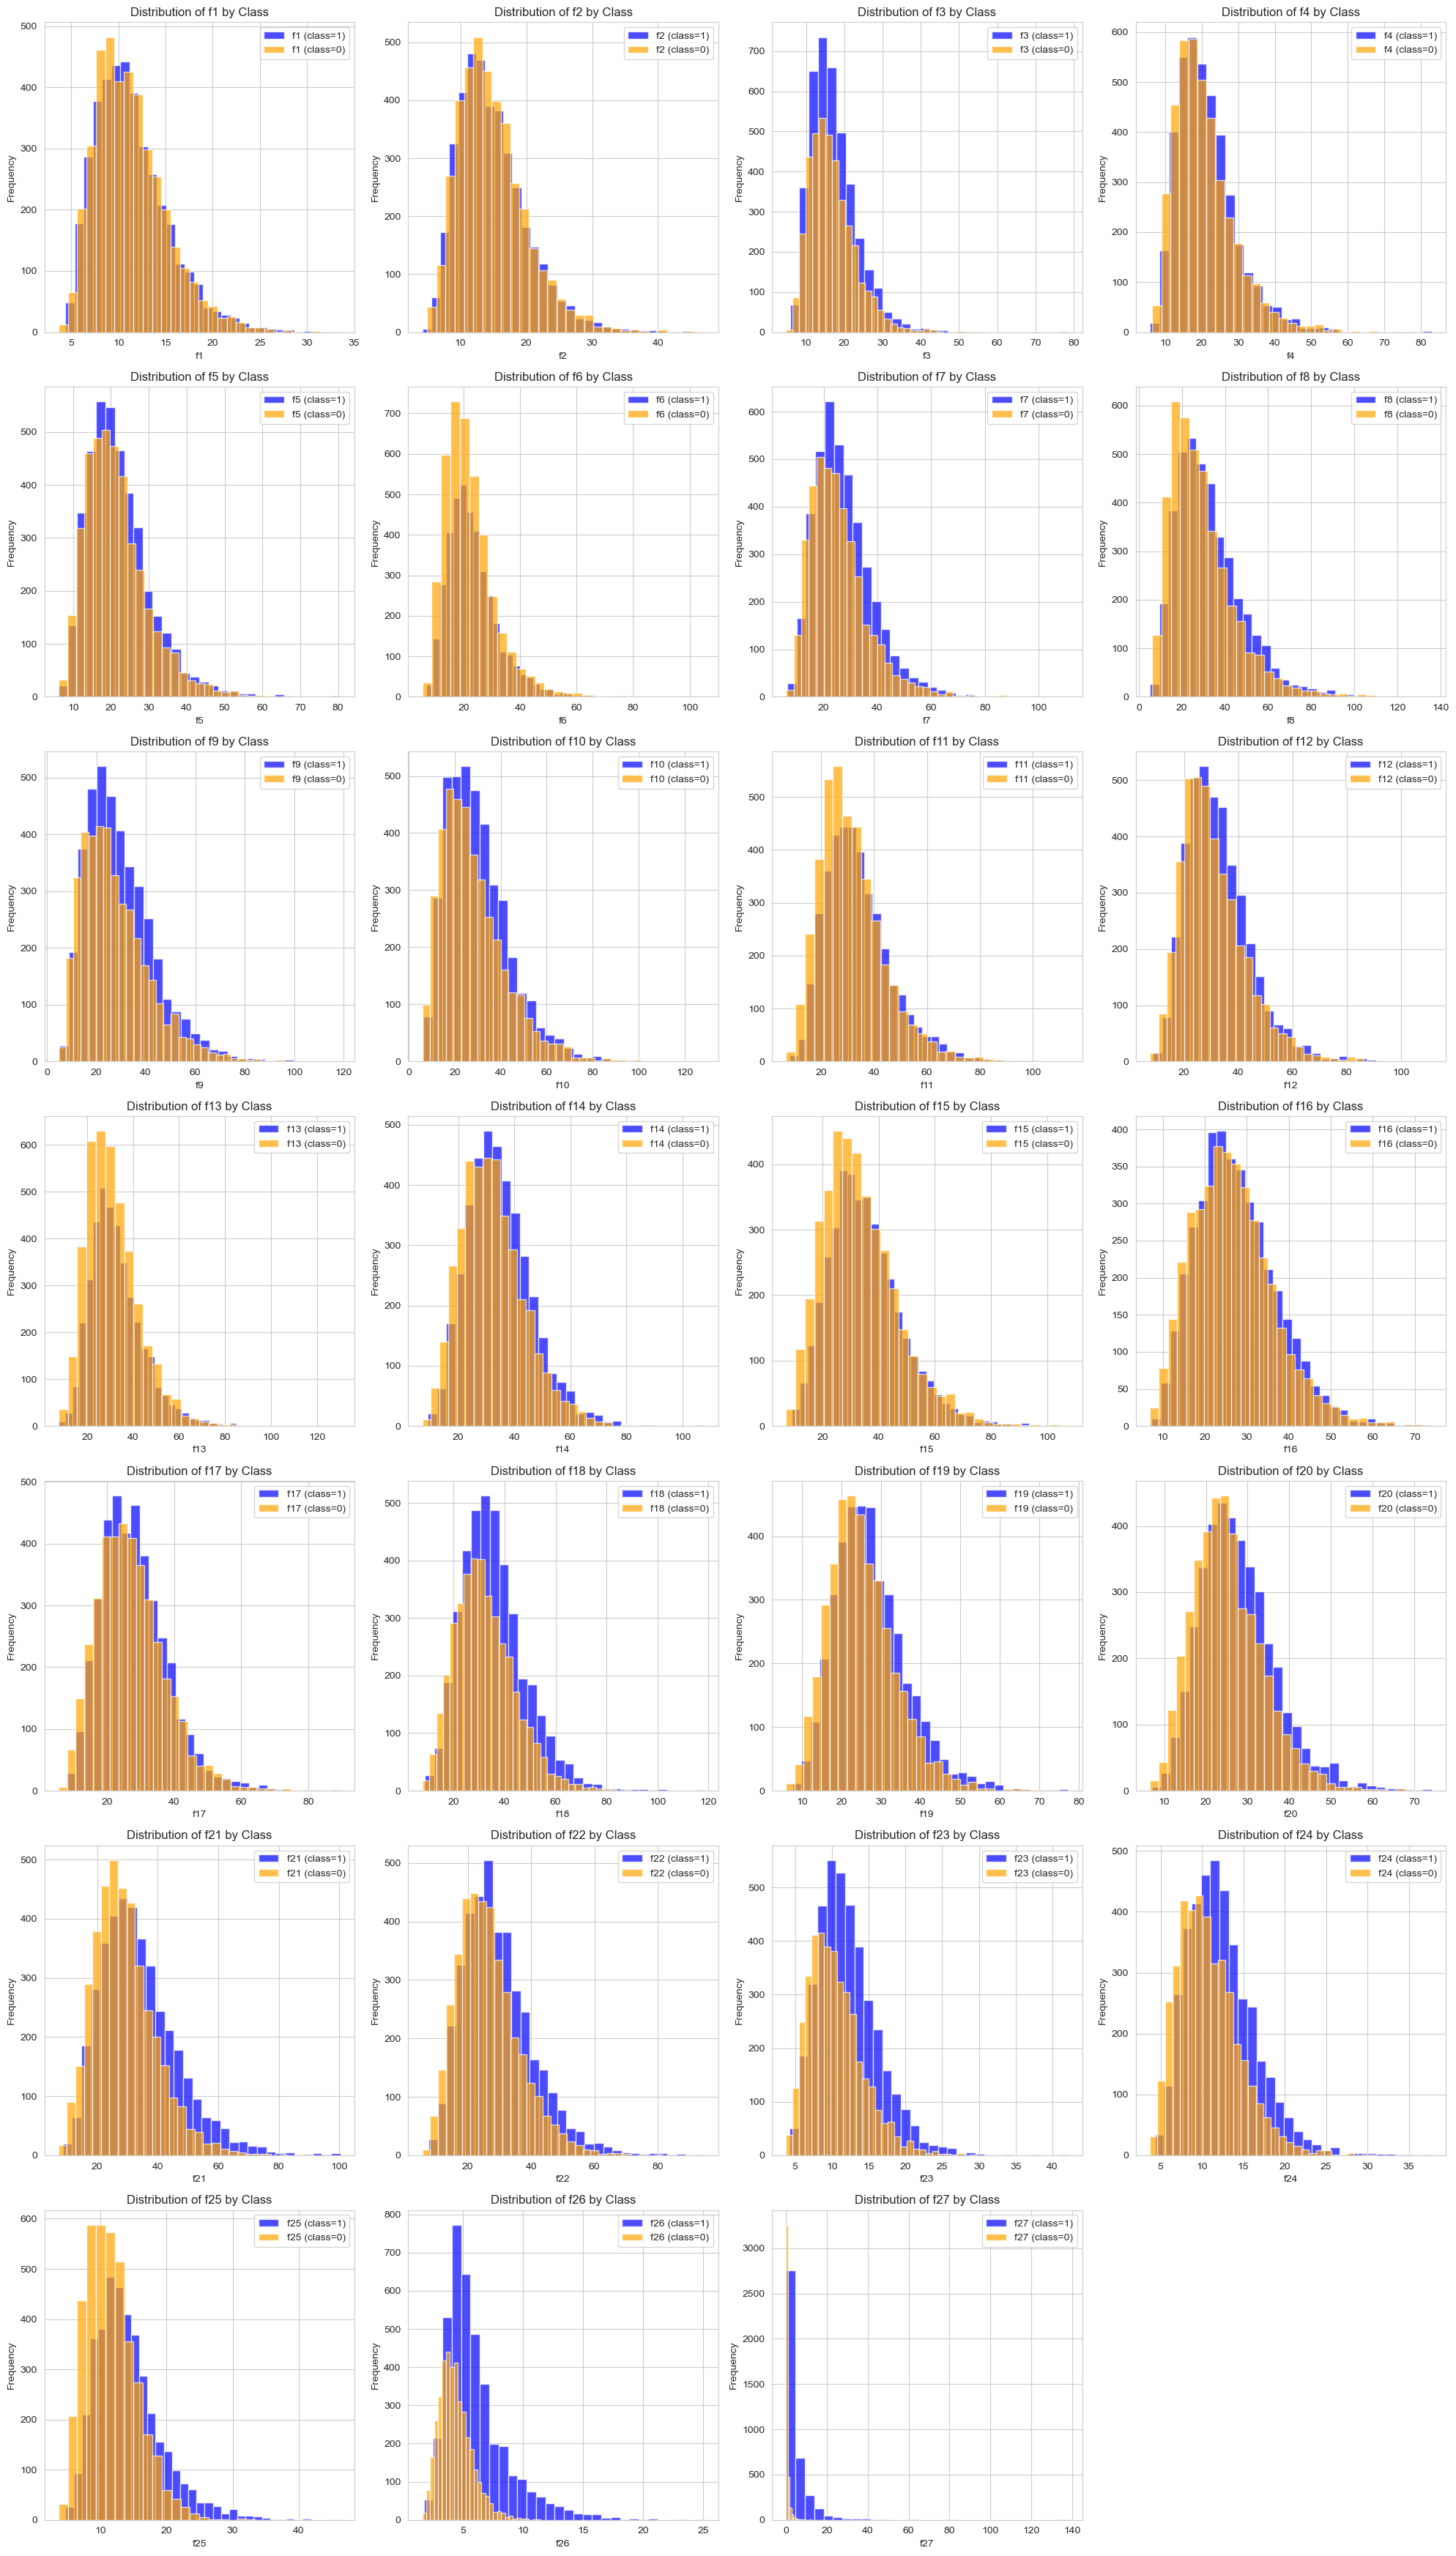

In [6]:
# Separate data by class
class_1 = train_data[train_data['class'] == 1]
class_0 = train_data[train_data['class'] == 0]

# Plot the distribution of each feature for both classes
n_cols = 4 
n_rows = -(-len(fs) // n_cols)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))

for i, feature in enumerate(fs):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.hist(class_1[feature], bins=30, alpha=0.7, label=f'{feature} (class=1)', color='blue')
    ax.hist(class_0[feature], bins=30, alpha=0.7, label=f'{feature} (class=0)', color='orange')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {feature} by Class')
    ax.legend()

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

In [8]:
# Try to select feature by Logistics regression
# No improvement, forget about it
X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())
selected_features = result.pvalues[result.pvalues < 0.05].index
#fs = selected_features.drop('const')
#X = train_data[fs]
#X = X[fs]
#y = train_data['class']
#X_test = test_data[fs]

Optimization terminated successfully.
         Current function value: 0.380151
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 7753
Model:                          Logit   Df Residuals:                     7725
Method:                           MLE   Df Model:                           27
Date:                Sat, 29 Jun 2024   Pseudo R-squ.:                  0.4514
Time:                        10:51:54   Log-Likelihood:                -2947.3
converged:                       True   LL-Null:                       -5372.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7057      0.198    -28.847      0.000      -6.093      -5.318
f1            -0.0096      0.

In [5]:
# Fit NearestNeighbors model to find the outlier
# Try, but No improvement of the model
nbrs = NearestNeighbors(n_neighbors=6).fit(X)
distances, indices = nbrs.kneighbors(X)
outliers = []

for i in range(len(X)):
    # Get the class of the neighbors excluding the sample itself
    neighbor_classes = y.iloc[indices[i][1:]]  # Exclude the sample itself
    sample_class = y.iloc[i]

    # Check if the sample class is different from all of its neighbors' classes
    if (all(neighbor_classes == 1) and sample_class == 0) or (all(neighbor_classes == 0) and sample_class == 1):
        outliers.append(i)

# Print the indices and values of the outliers
print(f'Outliers indices: {outliers}')
print(f'Outliers values:\n{train_data.iloc[outliers]}')



KeyboardInterrupt



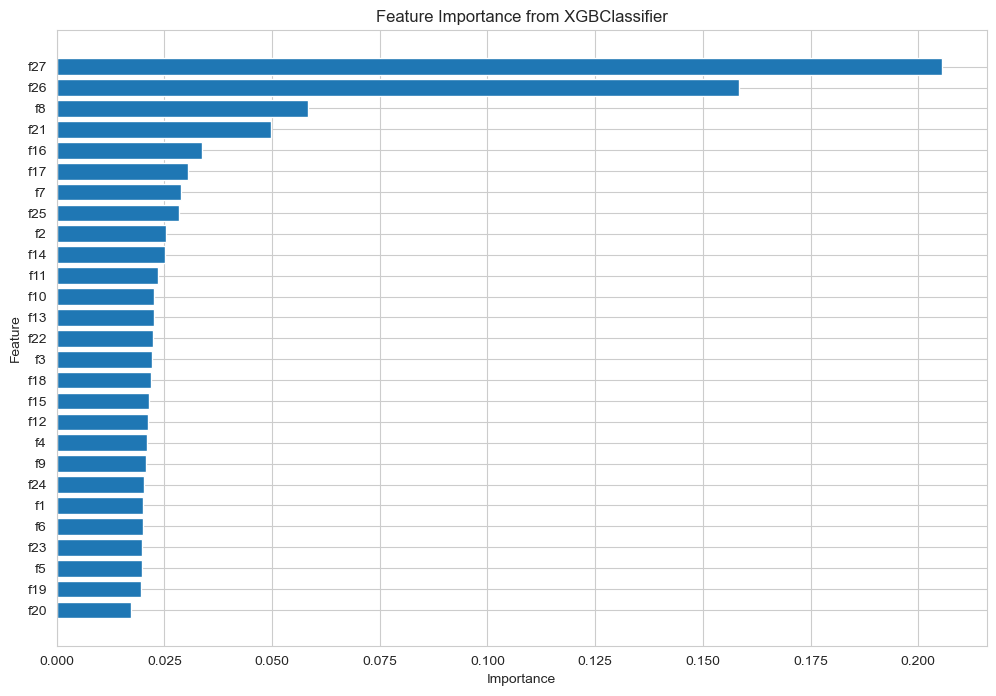

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=40)

#Find the feature importance from XGB Classifier
model = XGBClassifier(random_state=40)
model.fit(X_train, y_train)

feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': fs, 'importance': feature_importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBClassifier')
plt.gca().invert_yaxis()
plt.show()

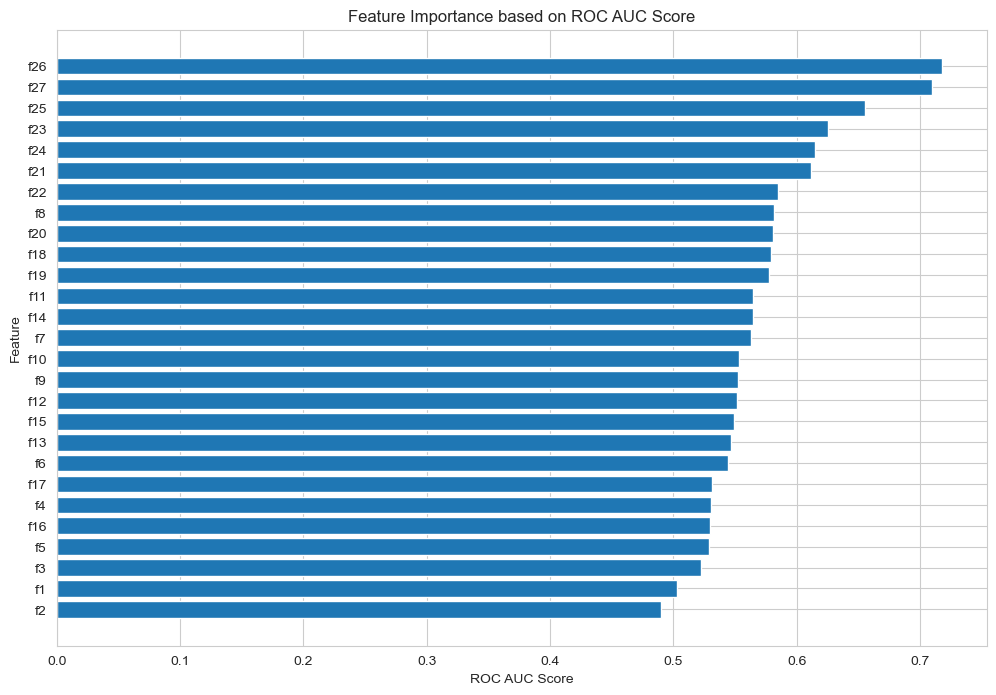

In [10]:
# find feature importance under logistic regression
from sklearn.model_selection import cross_val_score
feature_scores = []
for feature in fs:
    X_feature = X[[feature]]
    scores = cross_val_score(LogisticRegression(max_iter=1000), X_feature, y, cv=5, scoring='roc_auc')
    feature_scores.append((feature, scores.mean()))

feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)
scores_df = pd.DataFrame(feature_scores, columns=['feature', 'roc_auc'])

plt.figure(figsize=(12, 8))
plt.barh(scores_df['feature'], scores_df['roc_auc'])
plt.xlabel('ROC AUC Score')
plt.ylabel('Feature')
plt.title('Feature Importance based on ROC AUC Score')
plt.gca().invert_yaxis()
plt.show()

In [14]:
logging.basicConfig(level=logging.INFO)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=40)

In [15]:
# Define the parameter distributions for each model
param_dist_rf = {
    'n_estimators': randint(100, 250),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'bootstrap': [True, False]
}

param_dist_xgb = {
    'n_estimators': randint(100, 250),
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.01, 0.19),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

param_dist_gbc = {
    'n_estimators': randint(100, 250),
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.01, 0.19),
    'subsample': uniform(0.6, 0.4),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

param_dist_svc = {
    'C': uniform(0.1, 5),
    'gamma': uniform(0.001, 0.01),
    'kernel': ['rbf']
}

param_dist_catboost = {
    'iterations': randint(100, 250),
    'depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': uniform(1, 10)
}

In [16]:
kf = KFold(n_splits=8, shuffle=True, random_state=39)
def create_pipeline(estimator, param_dist, use_rfe=False):
    steps = []
    if use_rfe:
        steps.append(('rfe', RFE(estimator=estimator, n_features_to_select=15)))
    if param_dist:
        steps.append(('model', RandomizedSearchCV(estimator=estimator, param_distributions=param_dist, n_iter=50, cv=kf, n_jobs=-1, verbose=2, scoring='roc_auc', random_state=40)))
    else:
        steps.append(('model', estimator))
    pipeline = Pipeline(steps)
    return pipeline
pipelines = {
    'rf': create_pipeline(RandomForestClassifier(random_state=40), param_dist_rf),
    'xgb': create_pipeline(XGBClassifier(random_state=40), param_dist_xgb),
    'gbc': create_pipeline(GradientBoostingClassifier(random_state=40), param_dist_gbc),
    'svc': create_pipeline(SVC(probability=True, random_state=40, kernel='rbf'), param_dist_svc, use_rfe=False),
    'catboost': create_pipeline(CatBoostClassifier(random_state=40, verbose=0), param_dist_catboost)  # CatBoost with hyperparameter tuning
}

In [17]:
def train_and_select_best_models(pipelines, X, y):
    best_models = {}
    for model_name, pipeline in pipelines.items():
        logging.info(f"Training {model_name} model...")
        pipeline.fit(X, y)
        if isinstance(pipeline.named_steps['model'], RandomizedSearchCV):
            best_models[model_name] = pipeline.named_steps['model'].best_estimator_
        else:
            best_models[model_name] = pipeline.named_steps['model']
    return best_models

best_models = train_and_select_best_models(pipelines, X_train, y_train)

INFO:root:Training rf model...


Fitting 8 folds for each of 50 candidates, totalling 400 fits


INFO:root:Training xgb model...


Fitting 8 folds for each of 50 candidates, totalling 400 fits


INFO:root:Training gbc model...


Fitting 8 folds for each of 50 candidates, totalling 400 fits


INFO:root:Training svc model...


Fitting 8 folds for each of 50 candidates, totalling 400 fits


INFO:root:Training catboost model...


Fitting 8 folds for each of 50 candidates, totalling 400 fits


In [18]:
print(best_models)

{'rf': RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=171, random_state=40), 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.943636856520709, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0444118247966934,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=188, n_jobs=None,
              num_parallel_tree=None, random_state=40, ...), 'gbc': GradientBoostingClassifier(learning_rate=0.04906

In [20]:
auc_scores = {}
for model_name, model in best_models.items():
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_proba)
    auc_scores[model_name] = auc
    print(f"{model_name} AUC: {auc}")



rf AUC: 0.9225166951864529
xgb AUC: 0.9306865027334547
gbc AUC: 0.9261001877861239
svc AUC: 0.8550282790346238
catboost AUC: 0.9317483554824659


In [21]:
#Can change inside to use a single model to oredict
best = best_models['catboost']

test_predictions_proba = best.predict_proba(X_test)[:, 1]

In [22]:
#save to CSV
def save_predictions(test_data, predictions, output_path='submission.csv'):
    test_data['score'] = predictions
    submission = test_data[['ID', 'score']]
    submission.to_csv(output_path, index=False)
    logging.info(f"Predictions saved to {output_path}")

save_predictions(test_data, test_predictions_proba)

INFO:root:Predictions saved to submission.csv


In [23]:
#stacking and prediciton using logistic regression
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', best_models['rf']),
        ('xgb', best_models['xgb']),
        ('gbc', best_models['gbc']),
        #('svc', best_models['svc']),
        ('catboost', best_models['catboost'])
    ],
    final_estimator=LogisticRegression(),
    cv=kf
)
stacking_clf.fit(X_train, y_train)
y_val_pred_proba = stacking_clf.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_val_pred_proba)
logging.info(f"Stacking Classifier AUC: {auc}")


INFO:root:Stacking Classifier AUC: 0.932507416996311


In [24]:
test_predictions_proba = stacking_clf.predict_proba(X_test)[:, 1]
#Save to CSV
def save_predictions(test_data, predictions, output_path='submission.csv'):
    test_data['score'] = predictions
    submission = test_data[['ID', 'score']]
    submission.to_csv(output_path, index=False)
    logging.info(f"Predictions saved to {output_path}")

save_predictions(test_data, test_predictions_proba)

INFO:root:Predictions saved to submission.csv


AutoGluon

In [6]:
# Concatenate X and y for AutoGluon
X_scaled = StandardScaler().fit_transform(X)
train_data = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), y], axis=1)

#train_data = pd.concat([X, y], axis=1)

# Initialize AutoGluon predictor
predictor = TabularPredictor(
    label='class',
    eval_metric='roc_auc',
    path='ag_models'
)

# Train the predictor
predictor.fit(train_data, num_bag_folds=10, num_bag_sets = 15, num_stack_level = 4, time_limit=100800)  

# Evaluate on training data (AutoGluon handles its own validation split internally)
performance = predictor.evaluate(train_data)
print(performance)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
Memory Avail:       1.14 GB / 7.77 GB (14.7%)
Disk Space Avail:   581.33 GB / 930.41 GB (62.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 30800s
AutoGluon will save 

{'roc_auc': 0.9765432013115737, 'accuracy': 0.915625, 'balanced_accuracy': 0.9155719437682344, 'mcc': 0.8314741322648058, 'f1': 0.9142203583682806, 'precision': 0.9256304683479156, 'recall': 0.9030881245292494}


In [7]:
# Predict on test data
X_test_scaled = StandardScaler().fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns)
test_predictions = predictor.predict_proba(X_test_scaled)
#test_predictions = predictor.predict_proba(X_test)

# Check the shape of test_predictions to ensure correct indexing
print(test_predictions.shape)

# Assuming binary classification, get the probability of the positive class
if test_predictions.shape[1] == 2:
    test_predictions = test_predictions.iloc[:, 1]
else:
    raise ValueError("Expected binary classification but got different number of columns in predict_proba output.")

(4000, 2)


In [8]:
# Prepare submission file
submission = pd.DataFrame({
    'Id': test_data['ID'],
    'score': test_predictions
})
submission.to_csv('submission.csv', index=False)
print('Submission file created: submission.csv')

Submission file created: submission.csv


In [ ]:
submission

In [9]:
#check the best model
best_model = predictor.get_model_best()
print(f"The best model is: {best_model}")

#check the model parameter
models_info = predictor.info()
print(models_info)

C:\Users\User\AppData\Local\Temp\ipykernel_4780\877826631.py:2: DeprecationWarning: `get_model_best` has been deprecated and will be removed in version 1.2. Please use `model_best` instead. This will raise an error in the future!
  best_model = predictor.get_model_best()


The best model is: WeightedEnsemble_L2
{'path': 'ag_models', 'label': 'class', 'random_state': 0, 'version': '1.1.1', 'features': ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27'], 'feature_metadata_in': <autogluon.common.features.feature_metadata.FeatureMetadata object at 0x0000022B383512D0>, 'time_fit_preprocessing': 0.17999744415283203, 'time_fit_training': 5686.084697961807, 'time_fit_total': 5686.26469540596, 'time_limit': 30800, 'time_train_start': 1720142743.7250323, 'num_rows_train': 8000, 'num_cols_train': 27, 'num_rows_val': None, 'num_classes': 2, 'problem_type': 'binary', 'eval_metric': 'roc_auc', 'best_model': 'WeightedEnsemble_L2', 'best_model_score_val': 0.9370535817803208, 'best_model_stack_level': 2, 'num_models_trained': 14, 'num_bag_folds': 10, 'max_stack_level': 2, 'max_core_stack_level': 1, 'model_info': {'KNeighborsUnif_BAG_L1': {'name

TPOT

In [ ]:
import tpot

from tpot import TPOTClassifier

tpot = TPOTClassifier(
    generations=5,                
    population_size=50,            
    offspring_size=50,             
    mutation_rate=0.9,             
    crossover_rate=0.1,           
    verbosity=2,                   
    scoring='roc_auc',             
    max_eval_time_mins=5,          
    max_time_mins=None,            
    early_stop=5                   
)

# Fit the classifier
tpot.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = tpot.predict_proba(X_val)[:, 1]
val_score = roc_auc_score(y_val, y_val_pred)
print(f'Validation AUC Score: {val_score}')

Autosklearn

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import roc_auc

scorer = autosklearn.metrics.roc_auc

skf = StratifiedKFold(n_splits=5)
  
clf = AutoSklearnClassifier(resampling_strategy=skf,
                            time_left_for_this_task=1800,  # Increase total time for the task
                            per_run_time_limit=600,   
                            metric = scorer,
                            scoring_functions = [roc_auc])

clf.fit(X = X_train, y = y_train)

clf.refit(X = X_train.copy(), y = y_train.copy())
dump(clf, 'model.joblib')
clf = load('model.joblib')

y_val_pred = clf.predict_proba(X_val)
val_score = autosklearn.metrics.roc_auc(y_val, y_val_pred[:, 1])
print(f'Validation AUC Score: {val_score}')